In [ ]:
!wget https://raw.githubusercontent.com/openforcefield/2023-workshop-vignettes/update-install-instructions/colab_setup.ipynb
%run colab_setup.ipynb
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

# Vectorized representations

In [1]:
import numpy
from openff.toolkit import ForceField, Molecule
from rich.pretty import pprint

from openff.interchange import Interchange

In [2]:
sage = ForceField("openff_unconstrained-2.0.0.offxml")
molecule = Molecule.from_smiles(r"F\C=C/F")
interchange = Interchange.from_smirnoff(sage, [molecule])

pprint(interchange.collections.keys())

dict_keys(['Bonds', 'Constraints', 'Angles', 'ProperTorsions', 'ImproperTorsions', 'vdW', 'Electrostatics'])

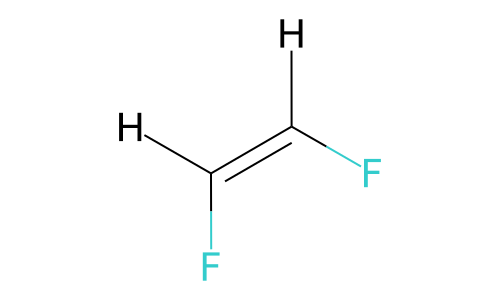

In [3]:
molecule.visualize()

`Interchange`s from SMIRNOFF force fields contain collections for several different types of parameters. For simplicity, let's look at the bond collection.

In [4]:
collection = interchange.collections["Bonds"]

`Collection`s store force field parameters and information about how they related to the topology they are applied to. In addition, they include some handy methods for transforming these to vectorized representations.

In [5]:
pprint(collection.get_force_field_parameters())

#      k (kcal/mol/Å),   length (Å)
#
# 0: [#6:1]-[#9:2]
# 1: [#6X3:1]=[#6X3:2]
# 2: [#6X3:1]-[#1:2]

array([[808.77100296,   1.35292621],
│      [798.31859066,   1.37168856],
│      [794.50915792,   1.0853585 ]])

`Collection.get_force_field_parameters` returns an array with one row per unique force field parameter used and one colum per number in each parameter. For this molecule, that means three rows (C-F, C#C, and C-H chemistries) and two columns (`k` and `length`). This matrix scales with the number of unique force field parameters used so it will not generally scale with system size.

In [6]:
pprint(collection.get_system_parameters())

#      k (kcal/mol/Å),   length (Å)
#
# bond0: (0, 1)
# bond1: (1, 2)
# bond2: (1, 4)
# bond3: (2, 3)
# bond4: (2, 5)

array([[808.77100296,   1.35292621],
│      [798.31859066,   1.37168856],
│      [794.50915792,   1.0853585 ],
│      [808.77100296,   1.35292621],
│      [794.50915792,   1.0853585 ]])

`Collection.get_system_field_parameters` returns a similar array but with one row per bond in the topology, including duplicates. Since there are two C-H and two C-F bonds, those parameters each appear twice. This matrix scales with the size of the system (in this case, number of bonds) so it may be large for large systems.

In [7]:
pprint(collection.get_param_matrix())

#      k0  l0   k1  l1   k2  l2
# bond0: k
# bond0: l
# bond1: k
# bond1: l
# bond2: k
# bond2: l
# bond3: k
# bond3: l
# bond4: k
# bond4: l

Array([[1., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0.],
│      [0., 0., 1., 0., 0., 0.],
│      [0., 0., 0., 1., 0., 0.],
│      [0., 0., 0., 0., 1., 0.],
│      [0., 0., 0., 0., 0., 1.],
│      [1., 0., 0., 0., 0., 0.],
│      [0., 1., 0., 0., 0., 0.],
│      [0., 0., 0., 0., 1., 0.],
│      [0., 0., 0., 0., 0., 1.]], dtype=float32)

It may be useful to encode the relationships between force field parameters and where in the topology they're applied. This is handled by `collection.get_param_matrix()`, which returns a spare matrix. Each column corresponds to a force field parameter and each row corresponds to a bond that could be associated with each, each dimension being a flattened representation of the above matrices. A 1 indicates that a parameter is applied to that bond, a 0 indicates that it is not. For example, the 1 at `[0, 0]` indicates that the first bond gets assigned the first `k` value. The 1 at `[7, 1]` indicates that the fourth bond gets assigned the first `length`.

Conveniently, the dot product of this matrix with a flattened view of the force field parameters is equal to the view of the system parameters we saw above.

In [8]:
dotted = numpy.dot(
    interchange["Bonds"].get_param_matrix(),
    interchange["Bonds"].get_force_field_parameters().flatten(),
).reshape((-1, 2))

assert numpy.allclose(dotted, collection.get_system_parameters())

pprint(dotted)

array([[808.77100296,   1.35292621],
│      [798.31859066,   1.37168856],
│      [794.50915792,   1.0853585 ],
│      [808.77100296,   1.35292621],
│      [794.50915792,   1.0853585 ]])